### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
t=-1

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.utils import shuffle
import xgboost as xgb
import catboost as cb

In [3]:
#---------- configs
pd.set_option('max_rows',100)
pd.set_option('max_columns',40)

### loading data

In [4]:
train_path = r"train.csv"
test_path = r"test.csv"

In [5]:
df = pd.read_csv(train_path,index_col=0,parse_dates=['Date'],dayfirst=True)
df_test = pd.read_csv(test_path,parse_dates=['Date'],dayfirst=True)

df = df.rename(columns={'Temperature(�C)':'Temperature(C)','Dew point temperature(�C)'  : 'Dew point temperature(C)'})
df_test = df_test.rename(columns={'Temperature(�C)':'Temperature(C)','Dew point temperature(�C)'  : 'Dew point temperature(C)'})

## Feature Engineering

##### based on the previous notebook (eda) we will consider the following 

- A) The Hourly cycle has a good correlation. [7am-18pm has the bigger share]
- B) The Temperature has good corr. [high is good except > ~ 27]
- C) The Functional Day has good corr. [functional is good for target]
- D) The Seasons has good corr. [hot season is better]

-------------

- E) The Visibility may prove to be good. [if encoded to very_low visibility vs normal visibiliy].
- F) The RainFall/SnowFall may prove to be good. [if encoded to Snowing / Raining or not].
- G) The Humidity may have something to investigate. [if encoded as 0-80 % normal rentals, 80-100% show sharp decay in rentals]

---------------
- H) the Dew point temperature is strongly corr to Temperature will drop it.
- I) the Solar Radiation may be discarded .. i didn't see good relation.
- J) the holidays didn't prove decisive saying on our target. maybe discarded too.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5760 entries, 0 to 5759
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      5760 non-null   datetime64[ns]
 1   y                         5760 non-null   int64         
 2   Hour                      5760 non-null   int64         
 3   Temperature(C)            5760 non-null   float64       
 4   Humidity(%)               5760 non-null   int64         
 5   Wind speed (m/s)          5760 non-null   float64       
 6   Visibility (10m)          5760 non-null   int64         
 7   Dew point temperature(C)  5760 non-null   float64       
 8   Solar Radiation (MJ/m2)   5760 non-null   float64       
 9   Rainfall(mm)              5760 non-null   float64       
 10  Snowfall (cm)             5760 non-null   float64       
 11  Seasons                   5760 non-null   object        
 12  Holiday             

In [7]:
df.describe()

,y,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000,5760.000000
mean,703.483854,11.500000,12.803559,58.361806,1.723333,1473.711458,4.058264,0.572325,0.135122,0.046302
std,655.249491,6.922788,11.902206,19.840167,1.047898,585.879880,13.003582,0.869943,1.075320,0.323728
min,0.000000,0.000000,-15.100000,0.000000,0.000000,27.000000,-26.900000,0.000000,0.000000,0.000000
25%,188.000000,5.750000,3.200000,43.000000,0.900000,1025.750000,-5.400000,0.000000,0.000000,0.000000
50%,485.500000,11.500000,13.700000,57.000000,1.500000,1732.000000,5.200000,0.010000,0.000000,0.000000
75%,1066.000000,17.250000,22.225000,73.000000,2.300000,2000.000000,14.700000,0.940000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,5.100000


In [8]:
len(df[(df['Snowfall (cm)'])>=1.5])

84

In [9]:
df['Seasons'].value_counts()

Autumn    1440
Summer    1440
Spring    1440
Winter    1440
Name: Seasons, dtype: int64

In [10]:
df_prep = df.copy()

In [11]:
df_prep['Year'] = df['Date'].dt.year.astype('int')
df_prep['Week'] = df['Date'].dt.isocalendar().week.astype('int')
df_prep['Month'] = df['Date'].dt.month.astype('int')
df_prep['WeekDay'] = df['Date'].dt.weekday.astype('int')

In [12]:
def restore_data_series(dataframe,dforiginal,col_name):
    dataframe[col_name] = dforiginal[col_name]

In [13]:
def map_data_series(dataframe,col_name,from_vals,to_vals):
    dataframe[col_name].replace(from_vals,to_vals,inplace=True)

In [14]:
def new_feature_data_series(dataframe,col_name,function,new_col_name):
       dataframe[new_col_name]  = dataframe[col_name].apply(function,axis=1)

In [15]:
map_data_series(df_prep,'Functioning Day',['Yes','No'],[1,0])

In [16]:
map_data_series(df_prep,'Holiday',['Holiday','No Holiday'],[1,0])

In [17]:
map_data_series(df_prep,'Seasons',['Winter','Spring','Summer','Autumn'],[0,1,2,3])

In [18]:
## lambda df : 0 if ( (abs(df['Hour'] - 8) <=rush_range_1) or (abs(df['Hour'] - 18) <= rush_range_2) ) else 1
def rush_hour(df):
    #rush_range_1 = 2 # around the rush hour by +- 2 hrs
    #rush_range_2 = 4 # around the rush hour by +- 4 hrs
    if (df['Hour'] in [6,7,8,9,10,16,17,18,19,20]):
        return 1
    else:
        return 0
    
def rush_hour_grad_2(df):
    rush_range_1 = 2 # around the rush hour by +- 2 hrs
    rush_range_2 = 5 # around the rush hour by +- 4 hrs
    is_functional = df['Functioning Day']

    return (np.exp(-abs(df['Hour'] - 8)) +  np.exp(-abs(df['Hour'] - 18))) * is_functional

def rush_hour_grad(df):
    #from 8 am , 6 pm
    rush_range_1 = 2 # around the rush hour by +- 2 hrs
    rush_range_2 = 5 # around the rush hour by +- 4 hrs
    is_functional = df['Functioning Day'] 
    
    if (abs(df['Hour'] - 8) <= rush_range_1): 
        return np.exp(-abs(df['Hour'] - 8)) * is_functional
    
    elif (abs(df['Hour'] - 18) <= rush_range_2):
        return np.exp(-abs(df['Hour'] - 18)) * is_functional
    else:
        return 0
    
def dead_hour_grad(df):
    dead_range_1 = 3 # around the dead hour by +- 3 hrs from 4 am
    is_functional = df['Functioning Day'] 
    
    if (abs(df['Hour'] - 4) <= dead_range_1): 
        return np.exp(-abs(df['Hour'] - 4)) * is_functional
    else:
        return 0
    
def dead_hour_grad_2(df):
    #dead_range_1 = 5 # around the dead hour by +- 3 hrs from 4 am
    is_functional = df['Functioning Day'] 
    
    if(df['Hour'] in [22,23,0,1,2,3,4,5]):
        return np.exp(-abs(df['Hour'] - 4)) * is_functional
    else:
        return 0   
new_feature_data_series(df_prep,['Hour','Functioning Day'],rush_hour_grad,'Rush_hour')
new_feature_data_series(df_prep,['Hour','Functioning Day'],dead_hour_grad_2,'Dead_hour')

In [19]:
## lambda df : 0 if ( (abs(df['Hour'] - 8) <=rush_range_1) or (abs(df['Hour'] - 18) <= rush_range_2) ) else 1
def day_night(df):
    #rush_range_1 = 2 # around the rush hour by +- 2 hrs
    #rush_range_2 = 4 # around the rush hour by +- 4 hrs
    if (df['Hour'] >=6 and df['Hour'] <=18):
        return 1
    else:
        return 0

new_feature_data_series(df_prep,['Hour'],day_night,'day_night')

In [20]:
new_feature_data_series(df_prep,['Humidity(%)'],lambda df : 0 if (df['Humidity(%)'] <= 70) else 1,'Humidity_high')

In [21]:
new_feature_data_series(df_prep,['Temperature(C)'],lambda df : 0 if (df['Temperature(C)'] <= 35) else 1,'Temperature_high')

In [22]:
new_feature_data_series(df_prep,['Humidity(%)','Temperature(C)','Solar Radiation (MJ/m2)','Wind speed (m/s)'],lambda df : 0 if (df['Temperature(C)'] < 35) and (df['Humidity(%)'] < 70) and (df['Solar Radiation (MJ/m2)'] < 1.4) else 1,'Weather_bad')

In [23]:
#something is wrong in feels like equation
# def feels_like(df):
#     ### inputs temp & humidity , outputs feels like temp
#     ## equation heat_index = c1 + c2 T + c3 R + c4 TR + c5 T^2 + c6 R^2 +...
#     c1 = -8.78469475556
#     c2 = 1.61139411
#     c3 = 2.33854883889
#     c4 = -0.14611605
#     c5 = -0.012308094
#     c6 = -0.0164248277778
#     c7 = 0.002211732
#     c8 = 0.00072546
#     c9 = -0.000003582
#     T = df['Temperature(C)']
#     R = df['Humidity(%)']
#     is_functionalDay = df['Functioning Day']
#     HI = (c1) + (c2 * T) +( c3 * R) + (c4  * T * R )+ (c5 *( T**2 ))+ (c6 * (R**2)) + (c7 * (T**2) * R) + (c8 * T * (R**2)) + (c9 * (T**2) * (R**2))
#     #HI = c1 + (c2 * T) +( c3 * R )+ (c4  * T * R )+ (c5 * T**2 )
#     return HI 

#new_feature_data_series(df_prep,['Temperature(C)','Humidity(%)','Functioning Day'],feels_like,'Feels_like')
def humidex(df):
    ### humidex
    ## eq H = Tair + 5/9 * [(6.11 * e^5417.7530 * (a-b)) - 10 ]
    Tair = df['Temperature(C)']
    Tdew = df['Dew point temperature(C)']
    is_functionalDay = df['Functioning Day']
    a = 1/273.16
    b = 1/(273.15 + Tdew)
    Humidex = Tair + (5/9) * (6.11 * np.exp(5417.7530 * (a-b)) -10)
    return Humidex  
new_feature_data_series(df_prep,['Temperature(C)','Dew point temperature(C)','Functioning Day'],humidex,'Humidex')

In [24]:
df_prep['Ideal'] = df[['Temperature(C)', 'Wind speed (m/s)']] \
    .apply(lambda df: 1 if (df['Temperature(C)'] < 30 and df['Wind speed (m/s)'] < 2.8) else 0, axis = 1)

In [25]:
df_prep["Ideal"].value_counts()

1    4548
0    1212
Name: Ideal, dtype: int64

In [26]:
def visibility(df):
    #0:250 , 250:500 : 500:inf
    
    if df['Visibility (10m)'] <=250 :
        return 0
    elif df['Visibility (10m)'] <=350 :
        return 1
    elif df['Visibility (10m)'] <=450 :
        return 1
    elif df['Visibility (10m)'] <=550 :
        return 2
    elif df['Visibility (10m)'] <=650 :
        return 2
    elif df['Visibility (10m)'] <=850 :
        return 3
    elif df['Visibility (10m)'] <=1150 :
        return 3
    elif df['Visibility (10m)'] <=1350 :
        return 4
    else:
        return 5
    
new_feature_data_series(df_prep,['Visibility (10m)'],visibility,'Visibility_cat')

In [27]:
def visibility_dist(df):
    #0:250 , 250:500 : 500:inf
    
    if df['Visibility (10m)'] <100 :     #can't see
        return 1
    elif df['Visibility (10m)'] <400 :   # foggy
        return 2
    elif df['Visibility (10m)'] <1000 :  # low fog
        return 3
    elif df['Visibility (10m)'] <2000 :  # no fog (good vision)
        return 4
    elif df['Visibility (10m)'] <4000 :  # no fog (excellent vision)
        return 5
    else:
        return 5
    
new_feature_data_series(df_prep,['Visibility (10m)'],visibility_dist,'Visibility_dist')

In [28]:
# for rainfall

def rain_fall(df):
    # 0:2.5 , 
    
    if df['Rainfall(mm)'] < 0.5 :
        return 0
    else:
        return 1

new_feature_data_series(df_prep,['Rainfall(mm)'],rain_fall,'Rain_cat')

In [29]:
def snow_fall(df):
    # 0:2.5 , 
    
    if df['Snowfall (cm)'] == 0 :
        return 0
    else:
        return 1

new_feature_data_series(df_prep,['Snowfall (cm)'],snow_fall,'Snow_cat')

In [30]:
def Sunny_Hot (df):
    if ((df['Temperature(C)']>25)&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_hot (df):
    if ((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))\
                                   &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_hot(df):  
    if((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))\
                                                       &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Cloudy_hot(df): 
    if((df['Temperature(C)']>25)&(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_hot(df):  
    if((df['Temperature(C)']>25)&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def Night_hot(df): 
    if((df['Temperature(C)']>25)&(df['day_night']==0)
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

#len(sunny_hot)+len(Clear_hot)+len(PCloudy_hot)+len(Cloudy_hot)+len(Rain_hot)+len(Night_hot)

In [31]:
def Sunny_Warm (df):
    if (((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Warm (df):
    if (((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
        &(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))&(df['day_night']==1))\
        &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Warm(df):  
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Cloudy_Warm(df): 
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_Warm(df):  
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def Night_Warm(df): 
    if(((df['Temperature(C)']<=25)&(df['Temperature(C)']>10))\
       &(df['day_night']==0)&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

In [32]:
def Sunny_Cold (df):
    if (((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Cold (df):
    if (((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
        &(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))&(df['day_night']==1))\
        &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Cloudy_Cold(df): 
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
       &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Snow_Cold(df):  
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))&(df['Rainfall(mm)'] ==0)&(df['Snowfall (cm)'] >0)):
        return True
    else:
        return False
def Night_Cold(df): 
    if(((df['Temperature(C)']<=10)&(df['Temperature(C)']>0))\
       &(df['day_night']==0)&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

In [33]:
def Sunny_Freezing (df):
    if ((df['Temperature(C)']<=0)&((df['Solar Radiation (MJ/m2)'] >2)&(df['day_night']==1))):
        return True
    else:
        return False

def Clear_Freezing (df):
    if ((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1))\
                                   &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False

def PCloudy_Freezing(df):  
    if((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5))\
                                                       &(df['day_night']==1))&(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Cloudy_Freezing(df): 
    if((df['Temperature(C)']<=0)&(((df['Solar Radiation (MJ/m2)'] <=0.5))&(df['day_night']==1))\
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_Freezing(df):  
    if((df['Temperature(C)']<=0)&(df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Snow_Freezing(df):  
    if((df['Temperature(C)']<=0)&(df['Rainfall(mm)'] ==0)&(df['Snowfall (cm)'] >0)):
        return True
    else:
        return False

def Night_Freezing(df): 
    if((df['Temperature(C)']<=0)&(df['day_night']==0)
                      &(df['Rainfall(mm)'] == 0)&(df['Snowfall (cm)'] == 0)):
        return True
    else:
        return False
def Rain_Snow(df):
    if (df['Rainfall(mm)'] >0)&(df['Snowfall (cm)'] >0):
        return True
    else:
        return False

#len(sunny_hot)+len(Clear_hot)+len(PCloudy_hot)+len(Cloudy_hot)+len(Rain_hot)+len(Night_hot)

In [34]:
df_prep['Weather_State'] =df_prep[['Temperature(C)', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: "Sunny_hot" if Sunny_Hot(df)\
           else "Clear_hot" if Clear_hot(df)\
           else "PCloudy_hot" if PCloudy_hot(df)\
           else "Cloudy_hot" if Cloudy_hot(df)\
           else "Rain_hot" if Rain_hot(df)\
           else "Night_hot" if Night_hot(df)\
           else "Sunny_Warm" if Sunny_Warm(df)\
           else "Clear_Warm" if Clear_Warm(df)\
           else "PCloudy_Warm" if PCloudy_Warm(df)\
           else "Cloudy_Warm" if Cloudy_Warm(df)\
           else "Rain_Warm" if Rain_Warm(df)\
           else "Night_Warm" if Night_Warm(df)\
           else "Sunny_Cold" if Sunny_Cold(df)\
           else "Clear_Cold" if Clear_Cold(df)\
           else "PCloudy_Cold" if PCloudy_Cold(df)\
           else "Cloudy_Cold" if Cloudy_Cold(df)\
           else "Rain_Cold" if Rain_Cold(df)\
           else "Snow_Cold" if Snow_Cold(df)\
           else "Night_Cold" if Night_Cold(df)\
           else "Sunny_Freezing" if Sunny_Freezing(df)\
           else "Clear_Freezing" if Clear_Freezing(df)\
           else "PCloudy_Freezing" if PCloudy_Freezing(df)\
           else "Cloudy_Freezing" if Cloudy_Freezing(df)\
           else "Rain_Freezing" if Rain_Freezing(df)\
           else "Snow_Freezing" if Snow_Freezing(df)\
           else "Night_Freezing" if Night_Freezing(df)\
           else "Rain&Snow" if Rain_Snow(df)\
           else 0, axis = 1)

In [35]:
Weather_Description_list = ['Night_Freezing', 'Cloudy_Freezing', 'PCloudy_Freezing',
                            'Clear_Cold', 'PCloudy_Cold', 'Cloudy_Cold', 'Night_Cold',
                            'Rain_Cold', 'Clear_Freezing', 'Rain&Snow', 'Snow_Freezing',
                            'Snow_Cold', 'Sunny_Freezing', 'Sunny_Cold', 'Sunny_Warm',
                            'Clear_Warm', 'PCloudy_Warm', 'Cloudy_Warm', 'Night_Warm',
                            'Rain_Warm', 'Sunny_hot', 'Clear_hot', 'Cloudy_hot', 'Night_hot',
                            'PCloudy_hot', 'Rain_hot']
length = len(Weather_Description_list)+1
Weather_Description_neumeric = [*range(1, length, 1)]

In [36]:
map_data_series(df_prep,'Weather_State',Weather_Description_list,Weather_Description_neumeric)

In [37]:
new_feature_data_series(df_prep,['Weather_State','Visibility_dist'],lambda df :df['Weather_State']*(df['Visibility_dist']),'Weather_stat&visb_dist')

In [38]:
new_feature_data_series(df_prep,['Weather_State','Visibility (10m)'],lambda df :df['Weather_State']*np.log(df['Visibility (10m)']),'Weather&visb')

In [39]:
def Clear(df):
    if (df['Solar Radiation (MJ/m2)'] >2) & (df['day_night'] ==1):
        return 1
    else:
        return 0
    
def Few_Clouds(df):
    if (((df['Solar Radiation (MJ/m2)'] <=2)&(df['Solar Radiation (MJ/m2)'] >1.5)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Scatterd_Clouds(df):
    if (((df['Solar Radiation (MJ/m2)'] <=1.5)&(df['Solar Radiation (MJ/m2)'] >1)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Partly_Cloudy(df):
    if (((df['Solar Radiation (MJ/m2)'] <=1)&(df['Solar Radiation (MJ/m2)'] >0.5)) & (df['day_night'] ==1)):
        return 1  
    else:
        return 0
    
def Cloudy(df):
    if ((df['Solar Radiation (MJ/m2)'] <= 0.5) & (df['day_night'] ==1)):
        return 1
    else:
        return 0
    
def Night(df):
    if ((df['Solar Radiation (MJ/m2)'] <= 0.8) & (df['day_night'] ==0)):
        return 1
    else:
        return 0
    

In [40]:
def Mist(df):
    if df['Visibility_dist'] == 3:
        return 1
    else:
        return 0
    
def Fog(df):
    if ((df['Visibility_dist'] == 1) | (df['Visibility_dist'] == 2)) :
        return 1
    else:
        return 0

In [41]:
def Light_Rain(df):
    if ((df['Rainfall(mm)']) >0 & (df['Rainfall(mm)'] < 2.5))  :
        return 1
    else:
        return 0
    
def Heavy_Rain(df):
    if (df['Rainfall(mm)'] >= 2.5)  :
        return 1
    else:
        return 0
def Ice_pallets(df):
        if ((df['Rainfall(mm)'] > 0 )& (df['Snowfall (cm)'] > 0 ))  :
            return 1
        else:
            return 0


In [42]:
def Light_Snow(df):
    if ((df['Snowfall (cm)']) >0 & (df['Snowfall (cm)'] < 1))  :
        return 1
    else:
        return 0
    
def Snow(df):
    if (df['Snowfall (cm)'] >= 1)  :
        return 1
    else:
        return 0

In [43]:
def Cond1(df):
    if Clear(df) or Few_Clouds(df) or Partly_Cloudy(df) or Cloudy(df):
        return 1
    else:
        return 0
def Cond2(df):
    if (Mist(df) and Cloudy(df)) or (Mist(df) and Partly_Cloudy(df)) or (Mist(df) and Few_Clouds(df)) or Mist(df):
        return 1
    else:
        return 0
def Cond3(df):
    if Light_Snow(df) or (Light_Rain(df) and Scatterd_Clouds(df)) or Light_Rain(df):
        return 1
    else:
        return 0
def Cond4(df):
    if (Ice_pallets(df) and Mist(df)) or (Snow(df) and Fog(df)) or Snow(df) :
        return 1
    else:
        return 0
def Cond5(df):
    if Night(df):
        return 1
    else:
        return 0

In [44]:
df_prep['Sky_State'] =df_prep[['Temperature(C)','Visibility_dist', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: 4 if Cond4(df)\
                 else 2 if Cond2(df)\
                 else 3 if Cond3(df)\
                 else 1 if Cond1(df)\
                 
                 else 5, axis = 1)

In [45]:
def Hot(df):
    if (df['Temperature(C)']>25):
        return 1
    else:
        return 0
def Warm(df):
    if ((df['Temperature(C)']<=25)&(df['Temperature(C)']>10)):
        return 1
    else:
        return 0
def Cold(df):
    if ((df['Temperature(C)']<=10)&(df['Temperature(C)']>0)):
        return 1
    else:
        return 0
def Freezing(df):
    if (df['Temperature(C)']<=0):
        return 1
    else:
        return 0

In [46]:
df_prep['Temp_State'] =df_prep[['Temperature(C)','Visibility_dist', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: 1 if Warm(df)\
                 else 2 if Cold(df)\
                 else 3 if Hot(df)\
                 else 4 if Freezing(df)\
                 
                 else 5, axis = 1)

In [47]:
df_prep[["Temp_State"]].value_counts()

Temp_State
1             2396
2             1358
3             1004
4             1002
dtype: int64

In [48]:
new_feature_data_series(df_prep,['Sky_State','Temp_State'],lambda df :df['Sky_State']*(df['Temp_State']),'GBL_Forecast')

In [49]:
df_prep["Date_tmp"] = df_prep['Date'].dt.to_period('M')
new_feature_df = pd.DataFrame(df_prep.groupby(['Date_tmp', 'Year'])['y'].mean()).sort_values(["Year"])
new_feature_df = pd.DataFrame(new_feature_df['y'].shift(+t))
new_feature_df.reset_index(inplace=True)
new_feature_df.rename(columns={'y':'Prev Month y'}, inplace=True)
new_feature_df.drop(['Year'], axis = 1, inplace =True)
new_feature_df.fillna(new_feature_df.mean(), inplace = True)

In [50]:
df_prep = pd.merge(df_prep, new_feature_df, on='Date_tmp', how='left')

In [51]:
df_prep["Temperature lag1"] = df_prep["Temperature(C)"].shift(+t)
df_prep["Temperature lag1"].fillna(0, inplace=True)




df_prep["Rainfall lag1"] = df_prep["Rainfall(mm)"].shift(+t)
df_prep["Rainfall lag1"].fillna(0, inplace=True)

df_prep["Visibility  lag1"] = df_prep["Visibility (10m)"].shift(+t)
df_prep["Visibility  lag1"].fillna(0, inplace=True)



df_prep["Wind speed lag1"] = df_prep["Wind speed (m/s)"].shift(+t)
df_prep["Wind speed lag1"].fillna(0, inplace=True)



df_prep["Weather_State lag1"] = df_prep["Weather_State"].shift(+t)
df_prep["Weather_State lag1"].fillna(0, inplace=True)



df_prep["Humidity lag1"] = df_prep["Humidity(%)"].shift(+t)
df_prep["Humidity lag1"].fillna(0, inplace=True)



df_prep["Humidity lag2"] = df_prep["Humidity(%)"].shift(+t-1)
df_prep["Humidity lag2"].fillna(0, inplace=True)

df_prep["Rainfall(mm) rolling"] =df_prep ["Rainfall(mm)"].rolling(2).sum()
df_prep["Rainfall(mm) rolling"].fillna(0, inplace=True)

df_prep["Wind speed (m/s) rolling"] =df_prep["Weather_State"].rolling(2).sum()
df_prep["Wind speed (m/s) rolling"].fillna(0, inplace=True)


df_prep["Rush_hour lag1"] = df_prep["Rush_hour"].shift(+t)
df_prep["Rush_hour lag1"].fillna(0, inplace=True)



df_prep["Dead_hour lag1"] = df_prep["Dead_hour"].shift(+t)
df_prep["Dead_hour lag1"].fillna(0, inplace=True)


df_prep["Ideal lag1"] = df_prep["Ideal"].shift(+t)
df_prep["Ideal lag1"].fillna(0, inplace=True)

df_prep["Ideal lag2"] = df_prep["Ideal"].shift(+t-1)
df_prep["Ideal lag2"].fillna(0, inplace=True)

df_prep["Rush_hour lag2"] = df_prep["Rush_hour"].shift(+t-1)
df_prep["Rush_hour lag2"].fillna(0, inplace=True)



df_prep["Dew point temperature(C) lag1"] = df_prep["Dew point temperature(C)"].shift(+t)
df_prep["Dew point temperature(C) lag1"].fillna(0, inplace=True)

In [52]:
df_prep.columns.size

53

In [53]:
df_prep.isna().sum()

Date                             0
y                                0
Hour                             0
Temperature(C)                   0
Humidity(%)                      0
Wind speed (m/s)                 0
Visibility (10m)                 0
Dew point temperature(C)         0
Solar Radiation (MJ/m2)          0
Rainfall(mm)                     0
Snowfall (cm)                    0
Seasons                          0
Holiday                          0
Functioning Day                  0
Year                             0
Week                             0
Month                            0
WeekDay                          0
Rush_hour                        0
Dead_hour                        0
day_night                        0
Humidity_high                    0
Temperature_high                 0
Weather_bad                      0
Humidex                          0
Ideal                            0
Visibility_cat                   0
Visibility_dist                  0
Rain_cat            

----
# Training The Model

####  Our Scoring Metric (RMSLE)

In [54]:
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    log_true = np.nan_to_num(np.array([np.log(y+1.0) for y in y_true]))
    log_pred = np.nan_to_num(np.array([np.log(y+1.0) for y in y_pred]))
    
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

def NumPyRMSLE(y_true:list, y_pred:list) -> float:
    """
        The Root Mean Squared Log Error (RMSLE) metric using only NumPy
        N.B. This function is a lot slower than sklearn's implementation
        
        :param y_true: The ground truth labels given in the dataset
        :param y_pred: Our predictions
        :return: The RMSLE score
    """
    n = len(y_true)
    msle = np.mean([(np.log(y_pred[i] + 1) - np.log(y_true[i] + 1)) ** 2.0 for i in range(n)])
    return np.sqrt(msle)

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False) 

##### Selecting features and splitting (do this everytime you change the features! and want to do training)

In [55]:

selected_features = ['Hour','Week', 'Month','Year', 'Solar Radiation (MJ/m2)','Rainfall(mm)',"Dew point temperature(C)",
                     'Snowfall (cm)','Wind speed (m/s)','Visibility (10m)','WeekDay',
                     'Seasons','Holiday' ,'Temperature(C)', 'Humidity(%)',
                     'Functioning Day','Rush_hour','Dead_hour','Weather_State',
                     'Weather&visb','Weather_stat&visb_dist','Sky_State','Temp_State','GBL_Forecast',
                     'Temperature lag1','Rainfall lag1', 'Visibility  lag1', 'Wind speed lag1',
                     'Weather_State lag1', 'Humidity lag1', 'Rush_hour lag1',
                     'Dead_hour lag1', 'Ideal lag1',"Dew point temperature(C) lag1","Humidity lag2","Rush_hour lag2","Ideal lag2",
                    "Rainfall(mm) rolling","Wind speed (m/s) rolling"]


train = df_prep.copy()
train["y"] = np.log(df_prep["y"]+0.00001) ##--- someone explain why this works better than +1
#train["y"] = df_prep["y"]
X1 = train[selected_features]
y1 = train["y"]

# tss = TimeSeriesSplit(n_splits=2)
# train_ind,test_ind  = tss.split(X1,groups=[20,1])

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.2, random_state=42,shuffle=True,)

In [56]:
len(selected_features)

39

---
## XGB

In [57]:
prev_trainX = 0
prev_testX = 0

In [58]:
XGB = xgb.XGBRegressor(n_estimators=2100,subsample=0.887
                       ,colsample_bytree = 0.9,colsample_bylevel=0.9,
                       learning_rate=0.056,n_jobs=8,max_depth =3)

XGB.fit(X_train, y_train)

y_pred_trainXGB = XGB.predict(X_train)   
y_pred_testXGB = XGB.predict(X_test)

rmsle_trainXGB =  rmsle(y_train, y_pred_trainXGB, True)
rmsle_testXGB  = rmsle(y_test, y_pred_testXGB, True)

print('(Train) RF RMSLE:',rmsle_trainXGB )
print('(Test) RF RMSLE:',rmsle_testXGB  )
print('---------------------------------' )
print('(Train) Prev RMSLE:', prev_trainX)
print('(Test) Prev RMSLE:', prev_testX)
prev_trainX = rmsle_trainXGB 
prev_testX = rmsle_testXGB 
print('---------------------------------' )
print("Training Score:", r2_score(y_train, y_pred_trainXGB) * 100,' %')
print("Test Score:", r2_score(y_test, y_pred_testXGB) * 100,' %')


(Train) RF RMSLE: 0.10767918388291556
(Test) RF RMSLE: 0.23247598921027107
---------------------------------
(Train) Prev RMSLE: 0
(Test) Prev RMSLE: 0
---------------------------------
Training Score: 99.91141594216658  %
Test Score: 99.64625763894061  %


<Figure size 864x576 with 0 Axes>

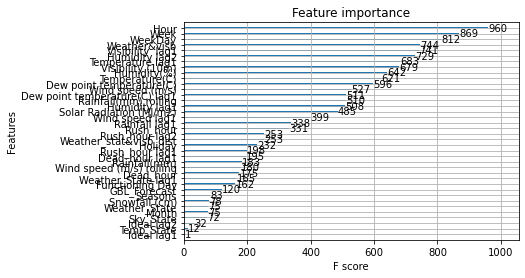

In [59]:
figure(figsize=(12, 8))
xgb.plot_importance(XGB)
plt.show()

In [60]:
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=5)
cv_score = cross_val_score(XGB, X_train, y_train, n_jobs=4, verbose = 1, cv=kfold, scoring=rmsle_scorer)
print(f'cv_error : {-cv_score.mean()}')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


cv_error : 0.26164645745866966


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   16.1s finished


---
## GBRegressor

In [61]:
prev_trainGBR = 0
prev_testGBR = 0

In [62]:
#GBR learn_rate = 0.05 , n_est = 1000 

GBR = GradientBoostingRegressor(random_state=0,loss='ls',
    n_estimators=1000,subsample=0.7,learning_rate=0.05,
    criterion='friedman_mse')

GBR.fit(X_train, y_train)

y_pred_trainGBR = GBR.predict(X_train)  
y_pred_testGBR = GBR.predict(X_test)  


rmsle_trainGBR =  rmsle(y_train, y_pred_trainGBR, True)
rmsle_testGBR  = rmsle(y_test, y_pred_testGBR, True)

print('(Train)  GBR  RMSLE:',rmsle_trainGBR )
print('(Test) GBR RMSLE:',rmsle_testGBR  )
print('---------------------------------' )
print('(Train) Prev RMSLE:', prev_trainGBR)
print('(Test) Prev RMSLE:', prev_testGBR)
prev_trainGBR = rmsle_trainGBR
prev_testGBR = rmsle_testGBR 
print('---------------------------------' )
print("Training Score:", r2_score(y_train, y_pred_trainGBR) * 100,' %')
print("Test Score:", r2_score(y_test, y_pred_testGBR) * 100,' %')

(Train)  GBR  RMSLE: 0.1584243829679516
(Test) GBR RMSLE: 0.23754886335517222
---------------------------------
(Train) Prev RMSLE: 0
(Test) Prev RMSLE: 0
---------------------------------
Training Score: 99.80734381998481  %
Test Score: 99.6323357194433  %


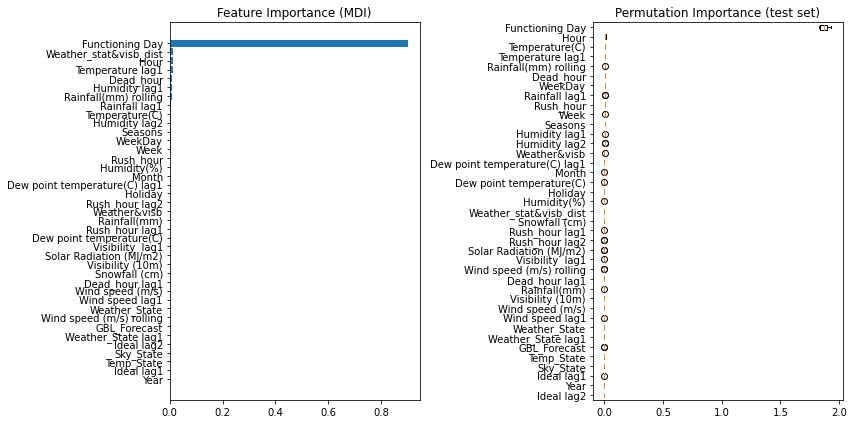

In [63]:
feature_importance = GBR.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
feature_names = list(X_train.columns.values)
plt.yticks(pos, np.array(feature_names)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(GBR, X_test, y_test, n_repeats=5,
                                random_state=42, n_jobs=4)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(feature_names)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

---
## CatBoost 

In [64]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)
#grid = {'depth': [4], 'iterations': [2500], 'l2_leaf_reg': [1], 'learning_rate': [0.05]} #0.42222

model = cb.CatBoostRegressor(loss_function='RMSE',random_state=0)
grid = {'depth': [4],'iterations': [2500], 'l2_leaf_reg': [1], 'learning_rate': [0.038]} ##0.4229364603151052

model.grid_search(grid, train_dataset)
pred_test = model.predict(X_test)
pred_train=model.predict(X_train)
# rmse= (np.sqrt(mean_squared_error(y_test, pred_test)))
# r2 = r2_score(y_test, pred_test)
print('(Test) CatBoost Regression RMSLE:', rmsle(y_test, pred_test, True))
print('(Train) CatBoost Regression RMSLE:', rmsle(y_train, pred_train, True))

0:	learn: 6.2857513	test: 6.2073859	best: 6.2073859 (0)	total: 158ms	remaining: 6m 34s
1:	learn: 6.0522199	test: 5.9745063	best: 5.9745063 (1)	total: 160ms	remaining: 3m 19s
2:	learn: 5.8290356	test: 5.7524499	best: 5.7524499 (2)	total: 161ms	remaining: 2m 14s
3:	learn: 5.6144646	test: 5.5391990	best: 5.5391990 (3)	total: 163ms	remaining: 1m 41s
4:	learn: 5.4087694	test: 5.3351344	best: 5.3351344 (4)	total: 165ms	remaining: 1m 22s
5:	learn: 5.2101222	test: 5.1397504	best: 5.1397504 (5)	total: 166ms	remaining: 1m 9s
6:	learn: 5.0191134	test: 4.9501996	best: 4.9501996 (6)	total: 168ms	remaining: 59.7s
7:	learn: 4.8350982	test: 4.7671773	best: 4.7671773 (7)	total: 170ms	remaining: 52.8s
8:	learn: 4.6595175	test: 4.5927647	best: 4.5927647 (8)	total: 172ms	remaining: 47.6s
9:	learn: 4.4901126	test: 4.4244498	best: 4.4244498 (9)	total: 174ms	remaining: 43.2s
10:	learn: 4.3278380	test: 4.2637365	best: 4.2637365 (10)	total: 176ms	remaining: 39.7s
11:	learn: 4.1711381	test: 4.1075720	best: 4.10

159:	learn: 0.4043406	test: 0.4117802	best: 0.4117802 (159)	total: 466ms	remaining: 6.81s
160:	learn: 0.4035389	test: 0.4109764	best: 0.4109764 (160)	total: 467ms	remaining: 6.79s
161:	learn: 0.4028044	test: 0.4102610	best: 0.4102610 (161)	total: 470ms	remaining: 6.79s
162:	learn: 0.4020962	test: 0.4095350	best: 0.4095350 (162)	total: 472ms	remaining: 6.76s
163:	learn: 0.4013444	test: 0.4087684	best: 0.4087684 (163)	total: 474ms	remaining: 6.75s
164:	learn: 0.4003039	test: 0.4075378	best: 0.4075378 (164)	total: 476ms	remaining: 6.73s
165:	learn: 0.3996195	test: 0.4068560	best: 0.4068560 (165)	total: 477ms	remaining: 6.71s
166:	learn: 0.3989419	test: 0.4063410	best: 0.4063410 (166)	total: 479ms	remaining: 6.69s
167:	learn: 0.3980381	test: 0.4056178	best: 0.4056178 (167)	total: 481ms	remaining: 6.68s
168:	learn: 0.3973604	test: 0.4049869	best: 0.4049869 (168)	total: 483ms	remaining: 6.66s
169:	learn: 0.3966990	test: 0.4042766	best: 0.4042766 (169)	total: 484ms	remaining: 6.64s
170:	learn

317:	learn: 0.3063752	test: 0.3196275	best: 0.3196275 (317)	total: 772ms	remaining: 5.29s
318:	learn: 0.3058938	test: 0.3194158	best: 0.3194158 (318)	total: 774ms	remaining: 5.29s
319:	learn: 0.3054349	test: 0.3190286	best: 0.3190286 (319)	total: 777ms	remaining: 5.29s
320:	learn: 0.3051144	test: 0.3188408	best: 0.3188408 (320)	total: 779ms	remaining: 5.29s
321:	learn: 0.3046857	test: 0.3184572	best: 0.3184572 (321)	total: 781ms	remaining: 5.28s
322:	learn: 0.3043764	test: 0.3182363	best: 0.3182363 (322)	total: 783ms	remaining: 5.28s
323:	learn: 0.3040741	test: 0.3181177	best: 0.3181177 (323)	total: 785ms	remaining: 5.27s
324:	learn: 0.3037362	test: 0.3179994	best: 0.3179994 (324)	total: 787ms	remaining: 5.26s
325:	learn: 0.3032811	test: 0.3177095	best: 0.3177095 (325)	total: 789ms	remaining: 5.26s
326:	learn: 0.3029598	test: 0.3175998	best: 0.3175998 (326)	total: 791ms	remaining: 5.25s
327:	learn: 0.3025339	test: 0.3174986	best: 0.3174986 (327)	total: 792ms	remaining: 5.25s
328:	learn

453:	learn: 0.2633725	test: 0.2908660	best: 0.2908660 (453)	total: 1.07s	remaining: 4.83s
454:	learn: 0.2631566	test: 0.2907370	best: 0.2907370 (454)	total: 1.07s	remaining: 4.83s
455:	learn: 0.2628455	test: 0.2906665	best: 0.2906665 (455)	total: 1.08s	remaining: 4.83s
456:	learn: 0.2626378	test: 0.2904494	best: 0.2904494 (456)	total: 1.08s	remaining: 4.82s
457:	learn: 0.2623378	test: 0.2902306	best: 0.2902306 (457)	total: 1.08s	remaining: 4.82s
458:	learn: 0.2620115	test: 0.2900721	best: 0.2900721 (458)	total: 1.08s	remaining: 4.82s
459:	learn: 0.2618924	test: 0.2899905	best: 0.2899905 (459)	total: 1.08s	remaining: 4.81s
460:	learn: 0.2616399	test: 0.2897667	best: 0.2897667 (460)	total: 1.09s	remaining: 4.8s
461:	learn: 0.2613166	test: 0.2894771	best: 0.2894771 (461)	total: 1.09s	remaining: 4.8s
462:	learn: 0.2611098	test: 0.2894661	best: 0.2894661 (462)	total: 1.09s	remaining: 4.8s
463:	learn: 0.2608811	test: 0.2892818	best: 0.2892818 (463)	total: 1.09s	remaining: 4.8s
464:	learn: 0.

597:	learn: 0.2329328	test: 0.2731900	best: 0.2731900 (597)	total: 1.37s	remaining: 4.35s
598:	learn: 0.2328372	test: 0.2731682	best: 0.2731682 (598)	total: 1.37s	remaining: 4.35s
599:	learn: 0.2325234	test: 0.2731926	best: 0.2731682 (598)	total: 1.37s	remaining: 4.35s
600:	learn: 0.2323545	test: 0.2730353	best: 0.2730353 (600)	total: 1.38s	remaining: 4.34s
601:	learn: 0.2322279	test: 0.2730157	best: 0.2730157 (601)	total: 1.38s	remaining: 4.34s
602:	learn: 0.2320900	test: 0.2729178	best: 0.2729178 (602)	total: 1.38s	remaining: 4.34s
603:	learn: 0.2319345	test: 0.2728080	best: 0.2728080 (603)	total: 1.38s	remaining: 4.34s
604:	learn: 0.2317804	test: 0.2725756	best: 0.2725756 (604)	total: 1.39s	remaining: 4.34s
605:	learn: 0.2314947	test: 0.2725291	best: 0.2725291 (605)	total: 1.39s	remaining: 4.34s
606:	learn: 0.2313807	test: 0.2724519	best: 0.2724519 (606)	total: 1.39s	remaining: 4.34s
607:	learn: 0.2312834	test: 0.2724347	best: 0.2724347 (607)	total: 1.39s	remaining: 4.34s
608:	learn

743:	learn: 0.2119004	test: 0.2640010	best: 0.2640010 (743)	total: 1.67s	remaining: 3.94s
744:	learn: 0.2118143	test: 0.2639855	best: 0.2639855 (744)	total: 1.67s	remaining: 3.93s
745:	learn: 0.2117152	test: 0.2638986	best: 0.2638986 (745)	total: 1.67s	remaining: 3.93s
746:	learn: 0.2114849	test: 0.2639925	best: 0.2638986 (745)	total: 1.67s	remaining: 3.93s
747:	learn: 0.2110679	test: 0.2638807	best: 0.2638807 (747)	total: 1.67s	remaining: 3.92s
748:	learn: 0.2109891	test: 0.2638275	best: 0.2638275 (748)	total: 1.68s	remaining: 3.92s
749:	learn: 0.2109228	test: 0.2638340	best: 0.2638275 (748)	total: 1.68s	remaining: 3.92s
750:	learn: 0.2107627	test: 0.2638394	best: 0.2638275 (748)	total: 1.68s	remaining: 3.91s
751:	learn: 0.2106983	test: 0.2637476	best: 0.2637476 (751)	total: 1.68s	remaining: 3.91s
752:	learn: 0.2105728	test: 0.2638664	best: 0.2637476 (751)	total: 1.68s	remaining: 3.9s
753:	learn: 0.2104738	test: 0.2637776	best: 0.2637476 (751)	total: 1.69s	remaining: 3.9s
754:	learn: 

892:	learn: 0.1948635	test: 0.2591769	best: 0.2591025 (889)	total: 1.97s	remaining: 3.55s
893:	learn: 0.1947758	test: 0.2591579	best: 0.2591025 (889)	total: 1.98s	remaining: 3.55s
894:	learn: 0.1947074	test: 0.2591494	best: 0.2591025 (889)	total: 1.98s	remaining: 3.55s
895:	learn: 0.1946239	test: 0.2591442	best: 0.2591025 (889)	total: 1.98s	remaining: 3.55s
896:	learn: 0.1945356	test: 0.2590186	best: 0.2590186 (896)	total: 1.98s	remaining: 3.54s
897:	learn: 0.1942450	test: 0.2589009	best: 0.2589009 (897)	total: 1.98s	remaining: 3.54s
898:	learn: 0.1941624	test: 0.2587831	best: 0.2587831 (898)	total: 1.99s	remaining: 3.54s
899:	learn: 0.1941052	test: 0.2587440	best: 0.2587440 (899)	total: 1.99s	remaining: 3.54s
900:	learn: 0.1939688	test: 0.2587710	best: 0.2587440 (899)	total: 1.99s	remaining: 3.54s
901:	learn: 0.1938421	test: 0.2587583	best: 0.2587440 (899)	total: 1.99s	remaining: 3.53s
902:	learn: 0.1937015	test: 0.2587447	best: 0.2587440 (899)	total: 2s	remaining: 3.53s
903:	learn: 0

1039:	learn: 0.1812426	test: 0.2559087	best: 0.2556782 (1031)	total: 2.27s	remaining: 3.19s
1040:	learn: 0.1811069	test: 0.2560964	best: 0.2556782 (1031)	total: 2.27s	remaining: 3.19s
1041:	learn: 0.1810375	test: 0.2560610	best: 0.2556782 (1031)	total: 2.27s	remaining: 3.18s
1042:	learn: 0.1809834	test: 0.2560857	best: 0.2556782 (1031)	total: 2.28s	remaining: 3.18s
1043:	learn: 0.1808539	test: 0.2561285	best: 0.2556782 (1031)	total: 2.28s	remaining: 3.18s
1044:	learn: 0.1807480	test: 0.2560884	best: 0.2556782 (1031)	total: 2.28s	remaining: 3.18s
1045:	learn: 0.1805376	test: 0.2561228	best: 0.2556782 (1031)	total: 2.28s	remaining: 3.17s
1046:	learn: 0.1804341	test: 0.2560143	best: 0.2556782 (1031)	total: 2.29s	remaining: 3.17s
1047:	learn: 0.1804112	test: 0.2560290	best: 0.2556782 (1031)	total: 2.29s	remaining: 3.17s
1048:	learn: 0.1803344	test: 0.2559854	best: 0.2556782 (1031)	total: 2.29s	remaining: 3.17s
1049:	learn: 0.1802744	test: 0.2559940	best: 0.2556782 (1031)	total: 2.29s	remai

1201:	learn: 0.1690561	test: 0.2535205	best: 0.2534510 (1188)	total: 2.58s	remaining: 2.78s
1202:	learn: 0.1690077	test: 0.2535390	best: 0.2534510 (1188)	total: 2.58s	remaining: 2.78s
1203:	learn: 0.1689863	test: 0.2535293	best: 0.2534510 (1188)	total: 2.58s	remaining: 2.78s
1204:	learn: 0.1689421	test: 0.2535237	best: 0.2534510 (1188)	total: 2.58s	remaining: 2.78s
1205:	learn: 0.1689002	test: 0.2535066	best: 0.2534510 (1188)	total: 2.58s	remaining: 2.77s
1206:	learn: 0.1688508	test: 0.2534711	best: 0.2534510 (1188)	total: 2.59s	remaining: 2.77s
1207:	learn: 0.1688015	test: 0.2534490	best: 0.2534490 (1207)	total: 2.59s	remaining: 2.77s
1208:	learn: 0.1687824	test: 0.2534301	best: 0.2534301 (1208)	total: 2.59s	remaining: 2.77s
1209:	learn: 0.1686944	test: 0.2533226	best: 0.2533226 (1209)	total: 2.59s	remaining: 2.77s
1210:	learn: 0.1686637	test: 0.2533194	best: 0.2533194 (1210)	total: 2.6s	remaining: 2.76s
1211:	learn: 0.1686226	test: 0.2533181	best: 0.2533181 (1211)	total: 2.6s	remaini

1350:	learn: 0.1598608	test: 0.2512559	best: 0.2511972 (1348)	total: 2.89s	remaining: 2.46s
1351:	learn: 0.1598076	test: 0.2512680	best: 0.2511972 (1348)	total: 2.89s	remaining: 2.45s
1352:	learn: 0.1597639	test: 0.2512536	best: 0.2511972 (1348)	total: 2.89s	remaining: 2.45s
1353:	learn: 0.1597354	test: 0.2512538	best: 0.2511972 (1348)	total: 2.9s	remaining: 2.45s
1354:	learn: 0.1597003	test: 0.2512440	best: 0.2511972 (1348)	total: 2.9s	remaining: 2.45s
1355:	learn: 0.1596683	test: 0.2512813	best: 0.2511972 (1348)	total: 2.9s	remaining: 2.44s
1356:	learn: 0.1596326	test: 0.2513075	best: 0.2511972 (1348)	total: 2.9s	remaining: 2.44s
1357:	learn: 0.1595868	test: 0.2512885	best: 0.2511972 (1348)	total: 2.9s	remaining: 2.44s
1358:	learn: 0.1594585	test: 0.2514156	best: 0.2511972 (1348)	total: 2.9s	remaining: 2.44s
1359:	learn: 0.1594004	test: 0.2513902	best: 0.2511972 (1348)	total: 2.9s	remaining: 2.44s
1360:	learn: 0.1593584	test: 0.2513736	best: 0.2511972 (1348)	total: 2.91s	remaining: 2

1504:	learn: 0.1511726	test: 0.2498501	best: 0.2498501 (1504)	total: 3.2s	remaining: 2.11s
1505:	learn: 0.1510665	test: 0.2498205	best: 0.2498205 (1505)	total: 3.2s	remaining: 2.11s
1506:	learn: 0.1510250	test: 0.2498045	best: 0.2498045 (1506)	total: 3.2s	remaining: 2.11s
1507:	learn: 0.1509772	test: 0.2498175	best: 0.2498045 (1506)	total: 3.2s	remaining: 2.11s
1508:	learn: 0.1508717	test: 0.2498074	best: 0.2498045 (1506)	total: 3.21s	remaining: 2.1s
1509:	learn: 0.1508247	test: 0.2498132	best: 0.2498045 (1506)	total: 3.21s	remaining: 2.1s
1510:	learn: 0.1507655	test: 0.2497662	best: 0.2497662 (1510)	total: 3.21s	remaining: 2.1s
1511:	learn: 0.1507119	test: 0.2497660	best: 0.2497660 (1511)	total: 3.21s	remaining: 2.1s
1512:	learn: 0.1506725	test: 0.2497704	best: 0.2497660 (1511)	total: 3.21s	remaining: 2.1s
1513:	learn: 0.1505587	test: 0.2496287	best: 0.2496287 (1513)	total: 3.22s	remaining: 2.1s
1514:	learn: 0.1505191	test: 0.2496041	best: 0.2496041 (1514)	total: 3.22s	remaining: 2.09

1656:	learn: 0.1429369	test: 0.2486590	best: 0.2486348 (1653)	total: 3.51s	remaining: 1.78s
1657:	learn: 0.1428701	test: 0.2486848	best: 0.2486348 (1653)	total: 3.51s	remaining: 1.78s
1658:	learn: 0.1428469	test: 0.2486826	best: 0.2486348 (1653)	total: 3.51s	remaining: 1.78s
1659:	learn: 0.1427749	test: 0.2486633	best: 0.2486348 (1653)	total: 3.51s	remaining: 1.78s
1660:	learn: 0.1427410	test: 0.2486626	best: 0.2486348 (1653)	total: 3.51s	remaining: 1.77s
1661:	learn: 0.1426857	test: 0.2486402	best: 0.2486348 (1653)	total: 3.52s	remaining: 1.77s
1662:	learn: 0.1426626	test: 0.2486109	best: 0.2486109 (1662)	total: 3.52s	remaining: 1.77s
1663:	learn: 0.1425929	test: 0.2486353	best: 0.2486109 (1662)	total: 3.52s	remaining: 1.77s
1664:	learn: 0.1425600	test: 0.2486263	best: 0.2486109 (1662)	total: 3.52s	remaining: 1.77s
1665:	learn: 0.1425370	test: 0.2486160	best: 0.2486109 (1662)	total: 3.52s	remaining: 1.76s
1666:	learn: 0.1425122	test: 0.2486116	best: 0.2486109 (1662)	total: 3.52s	remai

1814:	learn: 0.1358253	test: 0.2472963	best: 0.2472722 (1807)	total: 3.83s	remaining: 1.44s
1815:	learn: 0.1356471	test: 0.2472924	best: 0.2472722 (1807)	total: 3.83s	remaining: 1.44s
1816:	learn: 0.1356212	test: 0.2472875	best: 0.2472722 (1807)	total: 3.83s	remaining: 1.44s
1817:	learn: 0.1355919	test: 0.2472846	best: 0.2472722 (1807)	total: 3.83s	remaining: 1.44s
1818:	learn: 0.1355389	test: 0.2473114	best: 0.2472722 (1807)	total: 3.83s	remaining: 1.44s
1819:	learn: 0.1354976	test: 0.2473189	best: 0.2472722 (1807)	total: 3.84s	remaining: 1.43s
1820:	learn: 0.1354749	test: 0.2472952	best: 0.2472722 (1807)	total: 3.84s	remaining: 1.43s
1821:	learn: 0.1353991	test: 0.2472962	best: 0.2472722 (1807)	total: 3.84s	remaining: 1.43s
1822:	learn: 0.1353066	test: 0.2473191	best: 0.2472722 (1807)	total: 3.84s	remaining: 1.43s
1823:	learn: 0.1352938	test: 0.2473332	best: 0.2472722 (1807)	total: 3.84s	remaining: 1.42s
1824:	learn: 0.1352444	test: 0.2473281	best: 0.2472722 (1807)	total: 3.85s	remai

1956:	learn: 0.1294947	test: 0.2463238	best: 0.2463078 (1954)	total: 4.12s	remaining: 1.14s
1957:	learn: 0.1294639	test: 0.2463126	best: 0.2463078 (1954)	total: 4.12s	remaining: 1.14s
1958:	learn: 0.1294450	test: 0.2463027	best: 0.2463027 (1958)	total: 4.12s	remaining: 1.14s
1959:	learn: 0.1294107	test: 0.2462976	best: 0.2462976 (1959)	total: 4.13s	remaining: 1.14s
1960:	learn: 0.1293554	test: 0.2463276	best: 0.2462976 (1959)	total: 4.13s	remaining: 1.13s
1961:	learn: 0.1293291	test: 0.2463448	best: 0.2462976 (1959)	total: 4.13s	remaining: 1.13s
1962:	learn: 0.1292964	test: 0.2463361	best: 0.2462976 (1959)	total: 4.13s	remaining: 1.13s
1963:	learn: 0.1292446	test: 0.2463772	best: 0.2462976 (1959)	total: 4.13s	remaining: 1.13s
1964:	learn: 0.1291919	test: 0.2463418	best: 0.2462976 (1959)	total: 4.13s	remaining: 1.13s
1965:	learn: 0.1291586	test: 0.2463872	best: 0.2462976 (1959)	total: 4.14s	remaining: 1.12s
1966:	learn: 0.1291149	test: 0.2464151	best: 0.2462976 (1959)	total: 4.14s	remai

2104:	learn: 0.1241225	test: 0.2455691	best: 0.2455508 (2103)	total: 4.42s	remaining: 829ms
2105:	learn: 0.1240999	test: 0.2455531	best: 0.2455508 (2103)	total: 4.42s	remaining: 827ms
2106:	learn: 0.1240754	test: 0.2455518	best: 0.2455508 (2103)	total: 4.42s	remaining: 825ms
2107:	learn: 0.1240601	test: 0.2455435	best: 0.2455435 (2107)	total: 4.42s	remaining: 823ms
2108:	learn: 0.1240362	test: 0.2455306	best: 0.2455306 (2108)	total: 4.42s	remaining: 820ms
2109:	learn: 0.1239921	test: 0.2455152	best: 0.2455152 (2109)	total: 4.43s	remaining: 818ms
2110:	learn: 0.1239788	test: 0.2455092	best: 0.2455092 (2110)	total: 4.43s	remaining: 816ms
2111:	learn: 0.1239228	test: 0.2454943	best: 0.2454943 (2111)	total: 4.45s	remaining: 818ms
2112:	learn: 0.1238931	test: 0.2454989	best: 0.2454943 (2111)	total: 4.46s	remaining: 816ms
2113:	learn: 0.1238696	test: 0.2455046	best: 0.2454943 (2111)	total: 4.46s	remaining: 814ms
2114:	learn: 0.1237435	test: 0.2455101	best: 0.2454943 (2111)	total: 4.46s	remai

2242:	learn: 0.1196272	test: 0.2449415	best: 0.2449415 (2242)	total: 4.72s	remaining: 541ms
2243:	learn: 0.1196076	test: 0.2449153	best: 0.2449153 (2243)	total: 4.73s	remaining: 539ms
2244:	learn: 0.1195862	test: 0.2449232	best: 0.2449153 (2243)	total: 4.73s	remaining: 537ms
2245:	learn: 0.1195483	test: 0.2449590	best: 0.2449153 (2243)	total: 4.73s	remaining: 535ms
2246:	learn: 0.1195355	test: 0.2449817	best: 0.2449153 (2243)	total: 4.73s	remaining: 533ms
2247:	learn: 0.1195177	test: 0.2449771	best: 0.2449153 (2243)	total: 4.74s	remaining: 531ms
2248:	learn: 0.1194876	test: 0.2449813	best: 0.2449153 (2243)	total: 4.74s	remaining: 529ms
2249:	learn: 0.1194662	test: 0.2449752	best: 0.2449153 (2243)	total: 4.74s	remaining: 527ms
2250:	learn: 0.1194571	test: 0.2449961	best: 0.2449153 (2243)	total: 4.74s	remaining: 524ms
2251:	learn: 0.1194335	test: 0.2449996	best: 0.2449153 (2243)	total: 4.74s	remaining: 522ms
2252:	learn: 0.1194211	test: 0.2449971	best: 0.2449153 (2243)	total: 4.75s	remai

2386:	learn: 0.1155432	test: 0.2441258	best: 0.2441222 (2380)	total: 5.02s	remaining: 238ms
2387:	learn: 0.1155157	test: 0.2441209	best: 0.2441209 (2387)	total: 5.03s	remaining: 236ms
2388:	learn: 0.1154940	test: 0.2441056	best: 0.2441056 (2388)	total: 5.03s	remaining: 234ms
2389:	learn: 0.1154777	test: 0.2441100	best: 0.2441056 (2388)	total: 5.03s	remaining: 232ms
2390:	learn: 0.1154645	test: 0.2441099	best: 0.2441056 (2388)	total: 5.03s	remaining: 229ms
2391:	learn: 0.1154361	test: 0.2440926	best: 0.2440926 (2391)	total: 5.03s	remaining: 227ms
2392:	learn: 0.1154159	test: 0.2440878	best: 0.2440878 (2392)	total: 5.04s	remaining: 225ms
2393:	learn: 0.1154045	test: 0.2440822	best: 0.2440822 (2393)	total: 5.04s	remaining: 223ms
2394:	learn: 0.1153658	test: 0.2440890	best: 0.2440822 (2393)	total: 5.04s	remaining: 221ms
2395:	learn: 0.1153420	test: 0.2440739	best: 0.2440739 (2395)	total: 5.04s	remaining: 219ms
2396:	learn: 0.1153130	test: 0.2441160	best: 0.2440739 (2395)	total: 5.05s	remai

0:	learn: 6.2715891	test: 6.2715100	best: 6.2715100 (0)
1:	learn: 6.0394786	test: 6.0394858	best: 6.0394858 (1)
2:	learn: 5.8154856	test: 5.8155394	best: 5.8155394 (2)
3:	learn: 5.6017168	test: 5.6018803	best: 5.6018803 (3)
4:	learn: 5.3970169	test: 5.3972823	best: 5.3972823 (4)
5:	learn: 5.1983596	test: 5.1986722	best: 5.1986722 (5)
6:	learn: 5.0093463	test: 5.0101807	best: 5.0101807 (6)
7:	learn: 4.8266130	test: 4.8275230	best: 4.8275230 (7)
8:	learn: 4.6521996	test: 4.6535407	best: 4.6535407 (8)
9:	learn: 4.4838225	test: 4.4854041	best: 4.4854041 (9)
10:	learn: 4.3216554	test: 4.3232173	best: 4.3232173 (10)
11:	learn: 4.1647053	test: 4.1666456	best: 4.1666456 (11)
12:	learn: 4.0149282	test: 4.0171970	best: 4.0171970 (12)
13:	learn: 3.8716005	test: 3.8742982	best: 3.8742982 (13)
14:	learn: 3.7327770	test: 3.7351857	best: 3.7351857 (14)
15:	learn: 3.5983925	test: 3.6009991	best: 3.6009991 (15)
16:	learn: 3.4706827	test: 3.4731191	best: 3.4731191 (16)
17:	learn: 3.3472571	test: 3.34979

146:	learn: 0.4141671	test: 0.4294566	best: 0.4294566 (146)
147:	learn: 0.4121508	test: 0.4274833	best: 0.4274833 (147)
148:	learn: 0.4104785	test: 0.4258703	best: 0.4258703 (148)
149:	learn: 0.4093569	test: 0.4248400	best: 0.4248400 (149)
150:	learn: 0.4081873	test: 0.4237436	best: 0.4237436 (150)
151:	learn: 0.4073519	test: 0.4230511	best: 0.4230511 (151)
152:	learn: 0.4060082	test: 0.4218652	best: 0.4218652 (152)
153:	learn: 0.4049494	test: 0.4208201	best: 0.4208201 (153)
154:	learn: 0.4035550	test: 0.4195123	best: 0.4195123 (154)
155:	learn: 0.4022837	test: 0.4182578	best: 0.4182578 (155)
156:	learn: 0.4013604	test: 0.4173538	best: 0.4173538 (156)	total: 2.05s	remaining: 30.6s
157:	learn: 0.4005285	test: 0.4165379	best: 0.4165379 (157)
158:	learn: 0.3994453	test: 0.4155546	best: 0.4155546 (158)
159:	learn: 0.3982308	test: 0.4144942	best: 0.4144942 (159)
160:	learn: 0.3972153	test: 0.4135786	best: 0.4135786 (160)
161:	learn: 0.3963430	test: 0.4128501	best: 0.4128501 (161)
162:	learn

399:	learn: 0.2707604	test: 0.3156847	best: 0.3156847 (399)
400:	learn: 0.2705234	test: 0.3156290	best: 0.3156290 (400)
401:	learn: 0.2702747	test: 0.3154604	best: 0.3154604 (401)
402:	learn: 0.2700277	test: 0.3152559	best: 0.3152559 (402)
403:	learn: 0.2697493	test: 0.3150206	best: 0.3150206 (403)
404:	learn: 0.2694490	test: 0.3148136	best: 0.3148136 (404)
405:	learn: 0.2692669	test: 0.3147279	best: 0.3147279 (405)
406:	learn: 0.2690437	test: 0.3145791	best: 0.3145791 (406)
407:	learn: 0.2687582	test: 0.3144273	best: 0.3144273 (407)
408:	learn: 0.2684562	test: 0.3143524	best: 0.3143524 (408)
409:	learn: 0.2680996	test: 0.3142024	best: 0.3142024 (409)
410:	learn: 0.2676251	test: 0.3138365	best: 0.3138365 (410)
411:	learn: 0.2673649	test: 0.3135947	best: 0.3135947 (411)
412:	learn: 0.2671317	test: 0.3134639	best: 0.3134639 (412)
413:	learn: 0.2667587	test: 0.3131705	best: 0.3131705 (413)	total: 3.84s	remaining: 19.4s
414:	learn: 0.2665054	test: 0.3130765	best: 0.3130765 (414)
415:	learn

564:	learn: 0.2319217	test: 0.2959375	best: 0.2959375 (564)
565:	learn: 0.2317534	test: 0.2958294	best: 0.2958294 (565)
566:	learn: 0.2315428	test: 0.2957635	best: 0.2957635 (566)
567:	learn: 0.2314047	test: 0.2956863	best: 0.2956863 (567)
568:	learn: 0.2312443	test: 0.2956290	best: 0.2956290 (568)
569:	learn: 0.2310478	test: 0.2955449	best: 0.2955449 (569)
570:	learn: 0.2308529	test: 0.2954635	best: 0.2954635 (570)
571:	learn: 0.2305991	test: 0.2953195	best: 0.2953195 (571)
572:	learn: 0.2304044	test: 0.2953459	best: 0.2953195 (571)
573:	learn: 0.2302486	test: 0.2953053	best: 0.2953053 (573)
574:	learn: 0.2300575	test: 0.2951946	best: 0.2951946 (574)
575:	learn: 0.2299041	test: 0.2950492	best: 0.2950492 (575)
576:	learn: 0.2297157	test: 0.2949573	best: 0.2949573 (576)
577:	learn: 0.2295139	test: 0.2948634	best: 0.2948634 (577)
578:	learn: 0.2293720	test: 0.2948029	best: 0.2948029 (578)
579:	learn: 0.2292474	test: 0.2947534	best: 0.2947534 (579)
580:	learn: 0.2290743	test: 0.2946663	be

897:	learn: 0.1861024	test: 0.2777399	best: 0.2777399 (897)
898:	learn: 0.1859456	test: 0.2776871	best: 0.2776871 (898)
899:	learn: 0.1858007	test: 0.2776159	best: 0.2776159 (899)
900:	learn: 0.1857030	test: 0.2775643	best: 0.2775643 (900)
901:	learn: 0.1856270	test: 0.2775012	best: 0.2775012 (901)
902:	learn: 0.1855249	test: 0.2774766	best: 0.2774766 (902)
903:	learn: 0.1853756	test: 0.2773961	best: 0.2773961 (903)
904:	learn: 0.1852587	test: 0.2773957	best: 0.2773957 (904)
905:	learn: 0.1851433	test: 0.2773630	best: 0.2773630 (905)
906:	learn: 0.1850102	test: 0.2773495	best: 0.2773495 (906)
907:	learn: 0.1849313	test: 0.2773274	best: 0.2773274 (907)
908:	learn: 0.1848550	test: 0.2773016	best: 0.2773016 (908)	total: 7.91s	remaining: 13.8s
909:	learn: 0.1847919	test: 0.2772826	best: 0.2772826 (909)
910:	learn: 0.1847153	test: 0.2772722	best: 0.2772722 (910)
911:	learn: 0.1845973	test: 0.2772514	best: 0.2772514 (911)
912:	learn: 0.1844833	test: 0.2772077	best: 0.2772077 (912)
913:	learn

1087:	learn: 0.1695994	test: 0.2737061	best: 0.2736917 (1085)
1088:	learn: 0.1695346	test: 0.2737153	best: 0.2736917 (1085)
1089:	learn: 0.1694749	test: 0.2737052	best: 0.2736917 (1085)
1090:	learn: 0.1693872	test: 0.2736691	best: 0.2736691 (1090)
1091:	learn: 0.1693351	test: 0.2736867	best: 0.2736691 (1090)
1092:	learn: 0.1692446	test: 0.2736641	best: 0.2736641 (1092)
1093:	learn: 0.1691712	test: 0.2736708	best: 0.2736641 (1092)
1094:	learn: 0.1690965	test: 0.2736500	best: 0.2736500 (1094)
1095:	learn: 0.1690171	test: 0.2736069	best: 0.2736069 (1095)
1096:	learn: 0.1689358	test: 0.2736064	best: 0.2736064 (1096)
1097:	learn: 0.1688525	test: 0.2735651	best: 0.2735651 (1097)
1098:	learn: 0.1687984	test: 0.2735613	best: 0.2735613 (1098)	total: 9.26s	remaining: 11.8s
1099:	learn: 0.1686968	test: 0.2735612	best: 0.2735612 (1099)
1100:	learn: 0.1686082	test: 0.2735187	best: 0.2735187 (1100)
1101:	learn: 0.1684809	test: 0.2734943	best: 0.2734943 (1101)
1102:	learn: 0.1684109	test: 0.2734352	b

1314:	learn: 0.1534282	test: 0.2701220	best: 0.2701220 (1314)
1315:	learn: 0.1532759	test: 0.2701395	best: 0.2701220 (1314)
1316:	learn: 0.1532388	test: 0.2701443	best: 0.2701220 (1314)
1317:	learn: 0.1531693	test: 0.2701337	best: 0.2701220 (1314)
1318:	learn: 0.1530949	test: 0.2701066	best: 0.2701066 (1318)
1319:	learn: 0.1529867	test: 0.2700908	best: 0.2700908 (1319)
1320:	learn: 0.1529405	test: 0.2700759	best: 0.2700759 (1320)
1321:	learn: 0.1528758	test: 0.2700519	best: 0.2700519 (1321)
1322:	learn: 0.1528033	test: 0.2700350	best: 0.2700350 (1322)
1323:	learn: 0.1527134	test: 0.2700137	best: 0.2700137 (1323)
1324:	learn: 0.1526623	test: 0.2699867	best: 0.2699867 (1324)
1325:	learn: 0.1526068	test: 0.2699735	best: 0.2699735 (1325)
1326:	learn: 0.1525281	test: 0.2699685	best: 0.2699685 (1326)
1327:	learn: 0.1524382	test: 0.2699750	best: 0.2699685 (1326)
1328:	learn: 0.1523893	test: 0.2699739	best: 0.2699685 (1326)
1329:	learn: 0.1523272	test: 0.2699240	best: 0.2699240 (1329)
1330:	le

1509:	learn: 0.1420483	test: 0.2679692	best: 0.2679692 (1509)
1510:	learn: 0.1419809	test: 0.2679532	best: 0.2679532 (1510)
1511:	learn: 0.1419206	test: 0.2679552	best: 0.2679532 (1510)
1512:	learn: 0.1418704	test: 0.2679400	best: 0.2679400 (1512)
1513:	learn: 0.1417994	test: 0.2678782	best: 0.2678782 (1513)
1514:	learn: 0.1417539	test: 0.2678809	best: 0.2678782 (1513)
1515:	learn: 0.1417128	test: 0.2678589	best: 0.2678589 (1515)
1516:	learn: 0.1416736	test: 0.2678587	best: 0.2678587 (1516)
1517:	learn: 0.1416265	test: 0.2678526	best: 0.2678526 (1517)
1518:	learn: 0.1415825	test: 0.2678474	best: 0.2678474 (1518)
1519:	learn: 0.1415316	test: 0.2678453	best: 0.2678453 (1519)
1520:	learn: 0.1414348	test: 0.2678339	best: 0.2678339 (1520)
1521:	learn: 0.1413608	test: 0.2678392	best: 0.2678339 (1520)
1522:	learn: 0.1413128	test: 0.2678473	best: 0.2678339 (1520)
1523:	learn: 0.1412583	test: 0.2678246	best: 0.2678246 (1523)
1524:	learn: 0.1412349	test: 0.2678301	best: 0.2678246 (1523)
1525:	le

1709:	learn: 0.1321063	test: 0.2664775	best: 0.2664775 (1709)
1710:	learn: 0.1320621	test: 0.2664739	best: 0.2664739 (1710)
1711:	learn: 0.1320074	test: 0.2664816	best: 0.2664739 (1710)
1712:	learn: 0.1319624	test: 0.2664731	best: 0.2664731 (1712)
1713:	learn: 0.1319315	test: 0.2664645	best: 0.2664645 (1713)
1714:	learn: 0.1319039	test: 0.2664610	best: 0.2664610 (1714)
1715:	learn: 0.1318589	test: 0.2664466	best: 0.2664466 (1715)
1716:	learn: 0.1318330	test: 0.2664465	best: 0.2664465 (1716)
1717:	learn: 0.1317943	test: 0.2664462	best: 0.2664462 (1717)
1718:	learn: 0.1317381	test: 0.2664212	best: 0.2664212 (1718)
1719:	learn: 0.1317055	test: 0.2664057	best: 0.2664057 (1719)
1720:	learn: 0.1316835	test: 0.2664065	best: 0.2664057 (1719)
1721:	learn: 0.1316245	test: 0.2664168	best: 0.2664057 (1719)
1722:	learn: 0.1315521	test: 0.2664225	best: 0.2664057 (1719)
1723:	learn: 0.1315102	test: 0.2664170	best: 0.2664057 (1719)
1724:	learn: 0.1314563	test: 0.2663960	best: 0.2663960 (1724)
1725:	le

1855:	learn: 0.1259074	test: 0.2656561	best: 0.2656327 (1853)
1856:	learn: 0.1258688	test: 0.2656370	best: 0.2656327 (1853)
1857:	learn: 0.1258063	test: 0.2656469	best: 0.2656327 (1853)
1858:	learn: 0.1257688	test: 0.2656477	best: 0.2656327 (1853)
1859:	learn: 0.1257357	test: 0.2656400	best: 0.2656327 (1853)
1860:	learn: 0.1257086	test: 0.2656422	best: 0.2656327 (1853)
1861:	learn: 0.1256775	test: 0.2656270	best: 0.2656270 (1861)
1862:	learn: 0.1256430	test: 0.2656243	best: 0.2656243 (1862)
1863:	learn: 0.1256170	test: 0.2656233	best: 0.2656233 (1863)
1864:	learn: 0.1255862	test: 0.2656378	best: 0.2656233 (1863)
1865:	learn: 0.1255599	test: 0.2656352	best: 0.2656233 (1863)
1866:	learn: 0.1255219	test: 0.2656248	best: 0.2656233 (1863)
1867:	learn: 0.1254619	test: 0.2656257	best: 0.2656233 (1863)
1868:	learn: 0.1253928	test: 0.2656273	best: 0.2656233 (1863)
1869:	learn: 0.1253453	test: 0.2656124	best: 0.2656124 (1869)
1870:	learn: 0.1253142	test: 0.2656161	best: 0.2656124 (1869)
1871:	le

2010:	learn: 0.1198701	test: 0.2647829	best: 0.2647829 (2010)
2011:	learn: 0.1198305	test: 0.2647550	best: 0.2647550 (2011)
2012:	learn: 0.1198041	test: 0.2647506	best: 0.2647506 (2012)
2013:	learn: 0.1197750	test: 0.2647276	best: 0.2647276 (2013)
2014:	learn: 0.1196897	test: 0.2647300	best: 0.2647276 (2013)
2015:	learn: 0.1196696	test: 0.2647262	best: 0.2647262 (2015)
2016:	learn: 0.1196407	test: 0.2647283	best: 0.2647262 (2015)
2017:	learn: 0.1196131	test: 0.2647223	best: 0.2647223 (2017)
2018:	learn: 0.1195756	test: 0.2647144	best: 0.2647144 (2018)
2019:	learn: 0.1195517	test: 0.2647195	best: 0.2647144 (2018)
2020:	learn: 0.1195285	test: 0.2647210	best: 0.2647144 (2018)
2021:	learn: 0.1194925	test: 0.2647189	best: 0.2647144 (2018)
2022:	learn: 0.1194490	test: 0.2646981	best: 0.2646981 (2022)
2023:	learn: 0.1194292	test: 0.2646966	best: 0.2646966 (2023)
2024:	learn: 0.1193966	test: 0.2646936	best: 0.2646936 (2024)
2025:	learn: 0.1193792	test: 0.2646870	best: 0.2646870 (2025)
2026:	le

2285:	learn: 0.1106753	test: 0.2632928	best: 0.2632928 (2285)
2286:	learn: 0.1106294	test: 0.2632917	best: 0.2632917 (2286)
2287:	learn: 0.1106032	test: 0.2632828	best: 0.2632828 (2287)
2288:	learn: 0.1105733	test: 0.2632906	best: 0.2632828 (2287)
2289:	learn: 0.1105408	test: 0.2633030	best: 0.2632828 (2287)
2290:	learn: 0.1105193	test: 0.2633009	best: 0.2632828 (2287)
2291:	learn: 0.1104942	test: 0.2632977	best: 0.2632828 (2287)
2292:	learn: 0.1104664	test: 0.2633008	best: 0.2632828 (2287)
2293:	learn: 0.1104334	test: 0.2632966	best: 0.2632828 (2287)
2294:	learn: 0.1104078	test: 0.2632892	best: 0.2632828 (2287)
2295:	learn: 0.1103598	test: 0.2632839	best: 0.2632828 (2287)
2296:	learn: 0.1103350	test: 0.2632878	best: 0.2632828 (2287)
2297:	learn: 0.1102940	test: 0.2632817	best: 0.2632817 (2297)
2298:	learn: 0.1102657	test: 0.2632694	best: 0.2632694 (2298)
2299:	learn: 0.1102354	test: 0.2632525	best: 0.2632525 (2299)
2300:	learn: 0.1102014	test: 0.2632383	best: 0.2632383 (2300)
2301:	le

(Test) CatBoost Regression RMSLE: 0.22194602853791695
(Train) CatBoost Regression RMSLE: 0.12172936990348314


Text(0.5, 0, 'CatBoost Feature Importance')

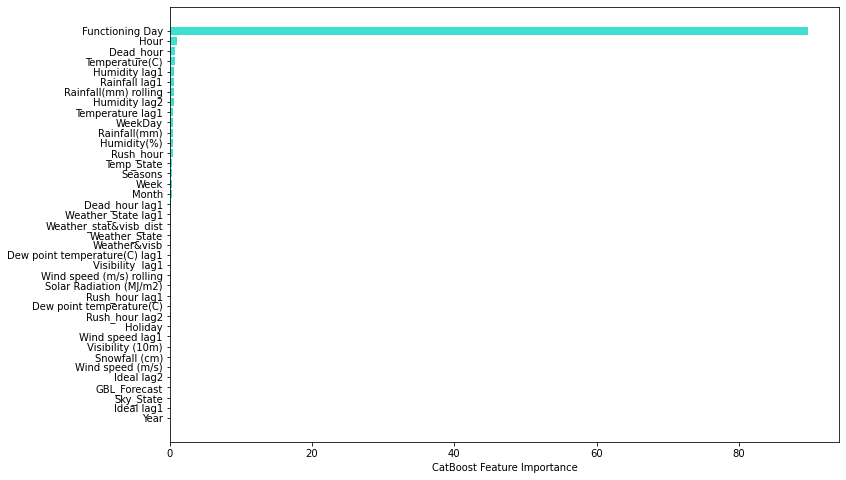

In [65]:
figure(figsize=(12,8))
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

---

### Submission Preparation

In [66]:
full_test_path = r"SeoulBikeDataTestFull.csv"

In [67]:
full_test = pd.read_csv(full_test_path)

In [68]:
test = df_test.copy()

In [69]:
test['Year'] = df_test['Date'].dt.year.astype('int')
test['Week'] = df_test['Date'].dt.isocalendar().week.astype('int')
test['Month'] = df_test['Date'].dt.month.astype('int') 
test['WeekDay'] = df_test['Date'].dt.weekday.astype('int')

In [70]:
#test.y.value_counts()

In [71]:
test.columns

Index(['ID', 'Date', 'Hour', 'Temperature(C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'Year', 'Week', 'Month', 'WeekDay'],
      dtype='object')

## Test Data Procc

In [72]:
map_data_series(test,'Functioning Day',['Yes','No'],[1,0])

In [73]:
map_data_series(test,'Holiday',['Holiday','No Holiday'],[1,0])

In [74]:
map_data_series(test,'Seasons',['Winter','Spring','Summer','Autumn'],[0,1,2,3])

In [75]:
new_feature_data_series(test,['Hour','Functioning Day'],dead_hour_grad_2,'Dead_hour')
new_feature_data_series(test,['Hour','Functioning Day'],rush_hour_grad,'Rush_hour')

In [76]:
new_feature_data_series(test,['Hour'],day_night,'day_night')
new_feature_data_series(test,['Humidity(%)'],lambda df : 0 if (df['Humidity(%)'] <= 70) else 1,'Humidity_high')
new_feature_data_series(test,['Temperature(C)'],lambda df : 0 if (df['Temperature(C)'] <= 35) else 1,'Temperature_high')

In [77]:
new_feature_data_series(test,['Humidity(%)','Temperature(C)','Solar Radiation (MJ/m2)'],lambda df : 0 if (df['Temperature(C)'] < 35) and (df['Humidity(%)'] < 70) and (df['Solar Radiation (MJ/m2)'] < 1.4) else 1,'Weather_bad')

In [78]:
test['Ideal'] = df_test[['Temperature(C)', 'Wind speed (m/s)']] \
    .apply(lambda df: 1 if (df['Temperature(C)'] < 30 and df['Wind speed (m/s)'] < 2.8) else 0, axis = 1)

In [79]:
#new_feature_data_series(test,['Temperature(C)','Humidity(%)','Functioning Day'],feels_like,'Feels_like')
new_feature_data_series(test,['Temperature(C)','Dew point temperature(C)','Functioning Day'],humidex,'Humidex')

In [80]:
new_feature_data_series(test,['Visibility (10m)'],visibility,'Visibility_cat')

In [81]:
new_feature_data_series(test,['Rainfall(mm)'],rain_fall,'Rain_cat')

In [82]:
new_feature_data_series(test,['Snowfall (cm)'],snow_fall,'Snow_cat')

In [83]:
test['Weather_State'] =test[['Temperature(C)', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: "Sunny_hot" if Sunny_Hot(df)\
           else "Clear_hot" if Clear_hot(df)\
           else "PCloudy_hot" if PCloudy_hot(df)\
           else "Cloudy_hot" if Cloudy_hot(df)\
           else "Rain_hot" if Rain_hot(df)\
           else "Night_hot" if Night_hot(df)\
           else "Sunny_Warm" if Sunny_Warm(df)\
           else "Clear_Warm" if Clear_Warm(df)\
           else "PCloudy_Warm" if PCloudy_Warm(df)\
           else "Cloudy_Warm" if Cloudy_Warm(df)\
           else "Rain_Warm" if Rain_Warm(df)\
           else "Night_Warm" if Night_Warm(df)\
           else "Sunny_Cold" if Sunny_Cold(df)\
           else "Clear_Cold" if Clear_Cold(df)\
           else "PCloudy_Cold" if PCloudy_Cold(df)\
           else "Cloudy_Cold" if Cloudy_Cold(df)\
           else "Rain_Cold" if Rain_Cold(df)\
           else "Snow_Cold" if Snow_Cold(df)\
           else "Night_Cold" if Night_Cold(df)\
           else "Sunny_Freezing" if Sunny_Freezing(df)\
           else "Clear_Freezing" if Clear_Freezing(df)\
           else "PCloudy_Freezing" if PCloudy_Freezing(df)\
           else "Cloudy_Freezing" if Cloudy_Freezing(df)\
           else "Rain_Freezing" if Rain_Freezing(df)\
           else "Snow_Freezing" if Snow_Freezing(df)\
           else "Night_Freezing" if Night_Freezing(df)\
           else "Rain&Snow" if Rain_Snow(df)\
           else 0, axis = 1)

In [84]:
map_data_series(test,'Weather_State',Weather_Description_list,Weather_Description_neumeric)

In [85]:
test["Date_tmp"] = test['Date'].dt.to_period('M')
test = pd.merge(test, new_feature_df, on="Date_tmp", how="left")

In [86]:
new_feature_data_series(test,['Visibility (10m)'],visibility_dist,'Visibility_dist')

In [87]:
new_feature_data_series(test,['Weather_State','Visibility_dist'],lambda df :df['Weather_State']*(df['Visibility_dist']),'Weather_stat&visb_dist')

In [88]:
new_feature_data_series(test,['Weather_State','Visibility (10m)'],lambda df :df['Weather_State']*np.log(df['Visibility (10m)']),'Weather&visb')

In [89]:
test['Sky_State'] =test[['Temperature(C)','Visibility_dist', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: 4 if Cond4(df)\
                 else 2 if Cond2(df)\
                 else 3 if Cond3(df)\
                 else 1 if Cond1(df)\
                 else 5, axis = 1)

In [90]:
test['Temp_State'] =test[['Temperature(C)','Visibility_dist', 'Solar Radiation (MJ/m2)' , 'day_night','Snowfall (cm)','Rainfall(mm)']]  \
    .apply(lambda df: 1 if Warm(df)\
                 else 2 if Cold(df)\
                 else 3 if Hot(df)\
                 else 4 if Freezing(df)\
                 
                 else 5, axis = 1)

In [91]:
new_feature_data_series(test,['Sky_State','Temp_State'],lambda df :df['Sky_State']*(df['Temp_State']),'GBL_Forecast')

In [92]:
test["Temperature lag1"] = test["Temperature(C)"].shift(+t)
test["Temperature lag1"].fillna(0, inplace=True)



test["Rainfall lag1"] = test["Rainfall(mm)"].shift(+t)
test["Rainfall lag1"].fillna(0, inplace=True)

test["Visibility  lag1"] = test["Visibility (10m)"].shift(+t)
test["Visibility  lag1"].fillna(0, inplace=True)



test["Wind speed lag1"] = test["Wind speed (m/s)"].shift(+t)
test["Wind speed lag1"].fillna(0, inplace=True)

test["Weather_State lag1"] = test["Weather_State"].shift(+t)
test["Weather_State lag1"].fillna(0, inplace=True)

test["Humidity lag1"] = test["Humidity(%)"].shift(+t)
test["Humidity lag1"].fillna(0, inplace=True)

test["Humidity lag2"] = test["Humidity(%)"].shift(+t-1)
test["Humidity lag2"].fillna(0, inplace=True)

test["Rainfall(mm) rolling"] =test["Rainfall(mm)"].rolling(2).sum()
test["Rainfall(mm) rolling"].fillna(0, inplace=True)

test["Wind speed (m/s) rolling"] =test["Weather_State"].rolling(2).sum()
test["Wind speed (m/s) rolling"].fillna(0, inplace=True)

test["Rush_hour lag1"] = test["Rush_hour"].shift(+t)
test["Rush_hour lag1"].fillna(0, inplace=True)

test["Rush_hour lag2"] = test["Rush_hour"].shift(+t-1)
test["Rush_hour lag2"].fillna(0, inplace=True)

test["Dead_hour lag1"] = test["Dead_hour"].shift(+t)
test["Dead_hour lag1"].fillna(0, inplace=True)



test["Ideal lag1"] = test["Ideal"].shift(+t)
test["Ideal lag1"].fillna(0, inplace=True)

test["Ideal lag2"] = test["Ideal"].shift(+t-1)
test["Ideal lag2"].fillna(0, inplace=True)

test["Dew point temperature(C) lag1"] = test["Dew point temperature(C)"].shift(+t)
test["Dew point temperature(C) lag1"].fillna(0, inplace=True)



In [93]:
#test.drop(["Date", "y", "Date_tmp", "Dataset"], axis=1, inplace=True)
Xtest = test[selected_features]
Xtest.columns

Index(['Hour', 'Week', 'Month', 'Year', 'Solar Radiation (MJ/m2)',
       'Rainfall(mm)', 'Dew point temperature(C)', 'Snowfall (cm)',
       'Wind speed (m/s)', 'Visibility (10m)', 'WeekDay', 'Seasons', 'Holiday',
       'Temperature(C)', 'Humidity(%)', 'Functioning Day', 'Rush_hour',
       'Dead_hour', 'Weather_State', 'Weather&visb', 'Weather_stat&visb_dist',
       'Sky_State', 'Temp_State', 'GBL_Forecast', 'Temperature lag1',
       'Rainfall lag1', 'Visibility  lag1', 'Wind speed lag1',
       'Weather_State lag1', 'Humidity lag1', 'Rush_hour lag1',
       'Dead_hour lag1', 'Ideal lag1', 'Dew point temperature(C) lag1',
       'Humidity lag2', 'Rush_hour lag2', 'Ideal lag2', 'Rainfall(mm) rolling',
       'Wind speed (m/s) rolling'],
      dtype='object')

### model Predictions 

## XGB

In [94]:
preds_expXGB = 0
def XGB_Full_predict():
    global preds_expXGB
    Xtest = test[selected_features]

    predsXGB = XGB.predict(Xtest)
    preds_expXGB = np.round(np.exp(predsXGB))

    print('(Full Test) XGB RMSLE:', rmsle(full_test.y, preds_expXGB, False))
    print("(Full Test) XGB R2 Score:", r2_score(full_test.y, preds_expXGB) * 100,' %')
XGB_Full_predict()

(Full Test) XGB RMSLE: 0.3040543491697487
(Full Test) XGB R2 Score: 92.80989155950732  %


## GBR

In [95]:
preds_expGBR = 0
def GBR_Full_predict():
    global preds_expGBR
    Gtest = test[selected_features]

    predsGBR = GBR.predict(Gtest)
    preds_expGBR = np.round(np.exp(predsGBR))

    print('(Full Test) XGB RMSLE:', rmsle(full_test.y, preds_expGBR, False))
    print("(Full Test) XGB R2 Score:", r2_score(full_test.y, preds_expGBR) * 100,' %')
GBR_Full_predict()

(Full Test) XGB RMSLE: 0.30619564784595554
(Full Test) XGB R2 Score: 92.66914409061668  %


### CatBoost

In [96]:
preds_expCat =0 
def Catboost_Full_predict():
    global preds_expCat
    Ctest = test[selected_features]

    predsCat = model.predict(Ctest)
    preds_expCat = np.round(np.exp(predsCat))

    print('(Full Test) XGB RMSLE:', rmsle(full_test.y, preds_expCat, False))
    print("(Full Test) XGB R2 Score:", r2_score(full_test.y, preds_expCat) * 100,' %')
Catboost_Full_predict()   

(Full Test) XGB RMSLE: 0.29794138498213446
(Full Test) XGB R2 Score: 92.82656594183493  %


## Stacking 2

In [97]:
def percy(v1,v2,precision=50):
    lowest_score = 1
    lowest_percentage = 0
    for i in np.linspace(0,1,precision):
        percentage_1 = i
        percentage_2 = 1-percentage_1
        score = rmsle(full_test.y, v1*percentage_1 + v2 *percentage_2, False)
        if  score < lowest_score:
            lowest_score = score
            lowest_percentage = i
    print(f'lowest score {lowest_score} , best_percentage v1 : {lowest_percentage},v2 : {1-lowest_percentage}')
    print("(Full Test) 2stack:", r2_score(full_test.y, v1*percentage_1 + v2 *percentage_2 ) * 100,' %')
    return lowest_percentage , 1-lowest_percentage

In [98]:
def percy_3valves(v1,v2,v3,precision=50):
    pv1_2,pv2_1 = percy(v1,v2,precision)
    pv1_3,pv3_1 = percy(v1,v3,precision)
    pv2_3,pv3_2 = percy(v2,v3,precision)
    p1 = (pv1_2 + pv1_3) / 3
    p2 = (pv2_1 + pv2_3) / 3
    p3 = (pv3_1 + pv3_2) / 3
    print('--------------------------------------------------------------------------------')
    print('(Full Test) rmsle 3_stacks: ',rmsle(full_test.y, v1*p1 + v2 *p2 +v3*p3 , False))
    print("(Full Test) 3stack:", r2_score(full_test.y, v1*p1 + v2 *p2 +v3*p3 ) * 100,' %')
    print(f'best_percentage v1 : {p1},v2 : {p2},v3 :  {p3}')
    return p1,p2,p3

In [99]:
def percy_R2(v1,v2,precision=50):
    highest_score = 0
    highest_percentage = 0
    for i in np.linspace(0,1,precision):
        p1 = i
        p2 = 1-p1
        score = r2_score(full_test.y, v1*p1 + v2 *p2 )
        if  score > highest_score:
            highest_score = score
            highest_percentage = i
    print(f'highest_score {highest_score} , best_percentage v1 : {highest_percentage},v2 : {1-highest_percentage}')
    return highest_percentage , 1-highest_percentage

In [100]:
def percy_3valves_R2(v1,v2,v3,precision=50):
    pv1_2,pv2_1 = percy_R2(v1,v2,precision)
    pv1_3,pv3_1 = percy_R2(v1,v3,precision)
    pv2_3,pv3_2 = percy_R2(v2,v3,precision)
    p1 = (pv1_2 + pv1_3) / 3
    p2 = (pv2_1 + pv2_3) / 3
    p3 = (pv3_1 + pv3_2) / 3
    print('(Full Test) rmsle 3_stacks: ',rmsle(full_test.y, v1*p1 + v2 *p2 +v3*p3 , False))
    print("(Full Test) 3stack:", r2_score(full_test.y, v1*p1 + v2 *p2 +v3*p3 ) * 100,' %')
    print(f'best_percentage v1 : {p1},v2 : {p2},v3 :  {p3}')
    return p1,p2,p3

In [101]:
percy_3valves_R2(preds_expGBR,preds_expCat,preds_expXGB,precision=50)


highest_score 0.9309168554977213 , best_percentage v1 : 0.44897959183673464,v2 : 0.5510204081632654
highest_score 0.93157537692404 , best_percentage v1 : 0.44897959183673464,v2 : 0.5510204081632654
highest_score 0.9326841158180718 , best_percentage v1 : 0.5102040816326531,v2 : 0.4897959183673469
(Full Test) rmsle 3_stacks:  0.2936518753696212
(Full Test) 3stack: 93.31083493389285  %
best_percentage v1 : 0.2993197278911564,v2 : 0.35374149659863946,v3 :  0.3469387755102041


(0.2993197278911564, 0.35374149659863946, 0.3469387755102041)

In [102]:
p1,p2,p3=percy_3valves(preds_expGBR,preds_expCat,preds_expXGB,precision=5)

lowest score 0.29558460746621995 , best_percentage v1 : 0.25,v2 : 0.75
(Full Test) 2stack: 92.66914409061668  %
lowest score 0.29911950400967896 , best_percentage v1 : 0.5,v2 : 0.5
(Full Test) 2stack: 92.66914409061668  %
lowest score 0.29297328523921073 , best_percentage v1 : 0.5,v2 : 0.5
(Full Test) 2stack: 92.82656594183493  %
--------------------------------------------------------------------------------
(Full Test) rmsle 3_stacks:  0.2931568928394217
(Full Test) 3stack: 93.31153918140511  %
best_percentage v1 : 0.25,v2 : 0.4166666666666667,v3 :  0.3333333333333333


### Save Submission

In [103]:
save_to_path = r'submissionamr.csv'
#0.2893713586123351

In [104]:
p1,p2,p3

(0.25, 0.4166666666666667, 0.3333333333333333)

In [105]:
test['y'] =  preds_expGBR*p1 + preds_expCat*p2 + preds_expXGB*p3
test[["ID", "y"]].to_csv(save_to_path, index=False)

In [106]:
test.y

0       137.583335
1       113.666667
2        88.833335
3        59.416667
4        36.916667
           ...    
2995    973.583333
2996    761.916677
2997    705.333338
2998    654.000005
2999    303.333338
Name: y, Length: 3000, dtype: float64